## Import all requirements and dependencies

In [ ]:
# Install all requirements for model selection.

!pip install bertopic
!pip install emoji
!pip install nltk
!pip install matplotlib
!pip install pyLDAvis
!pip install sentence-transformers scikit-learn pandas
!pip install gensim
!pip install altair
!pip install huggingface_hub

In [2]:
# Import all modules

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize

# tools
import itertools
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
from datetime import datetime
from huggingface_hub import snapshot_download
from datasets import load_dataset

# modeling
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel

# BERTopic
from bertopic import BERTopic
from umap import UMAP
from hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.representation import KeyBERTInspired
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import MaximalMarginalRelevance

/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


## Download datasets

In [ ]:
# Download nltk datasets
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

# Download load comments datasets.
dataset_path = snapshot_download(
    repo_id="Dragmoon/2025CalifoniaWildfire",
    repo_type="dataset",
    local_dir="./datasets"
)

# Show sample comments
comments = pd.read_csv(os.path.join(dataset_path, 'reddit/all_final_comments.csv'))
comments.head(10)

In [12]:
# Show corpus length
short_comments = comments[comments['corpus_length'] < 10]
long_comments = comments[comments['corpus_length'] >= 10]
corpus = long_comments['corpus'].to_list()
len(corpus)

77194

In [13]:
# Get stopwords from nltk
stop_words = set(stopwords.words('english'))

stop_words.update(['wildfire', 'fire', 'fires', 'la', 'california', 'angeles', 'los', 'the', 'to', 'it', 'of', 'thank', 'you'])

stop_words = list(stop_words)

In [14]:
# Set seed words to guide topics
seed_topic_list = [["watchduty", "calfire", "containment", "drone", "images", "active", "inmate", "wind", "spread", "superscoopers"],
                   ["air quality", "evacuate", "school", "ash", "smoke", "safety", "health", "selfies", "power", "medical"],
                   ["water", "temporary", "mask", "pump", "rental", "housing", "eggs", "hydrant", "food", "laundry"],
                   ["insurance", "law", "community", "relief", "donation", "restore", "clean", "mental", "rebuilding", "benefit"],
                   ["burned down", "gone", "damage", "structures", "survived", "cars", "destruction", "trails", "victim", "lost"],
                   ["responsibility", "pro bono", "influencer", "twitter", "trump", "mayor", "concert", "volunteer", "therapy", "celebrity"]
                   ]

## Models training and hyperparameter selection (Optional)

In [15]:
should_retrain_model = False

### Model training utils

In [16]:
# @title
# BERTopic Training Utils

def train_topic_model(corpus, embedding_model, umap_params, hdbscan_params, vectorizer_params,
                      ctfidf_model, representation_model, top_n_words=10):
    """
    Train a BERTopic model given the hyperparameters.
    """
    # Create UMAP and HDBSCAN models with provided parameters.
    #Step2
    umap_model = UMAP(**umap_params)
    #Step3
    hdbscan_model = HDBSCAN(**hdbscan_params)
    #Step4
    vectorizer_model = CountVectorizer(**vectorizer_params)

    topic_model = BERTopic(
        seed_topic_list=seed_topic_list,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        embedding_model=embedding_model,
        vectorizer_model=vectorizer_model,
        top_n_words=top_n_words,
        language='english',
        calculate_probabilities=True,
        verbose=True,
        ctfidf_model=ctfidf_model,
        representation_model=representation_model
    )

    topics, _ = topic_model.fit_transform(corpus)
    topic_info = topic_model.get_topic_info()
    return topic_model, topics, topic_info, vectorizer_model

def compute_coherence(topic_model, corpus):
    """
    Compute the c_v coherence score for a BERTopic model.
    """
    # Preprocess documents (using the model's internal method; caution as it's private)
    cleaned_docs = topic_model._preprocess_text(corpus)
    vectorizer = topic_model.vectorizer_model
    analyzer = vectorizer.build_analyzer()
    tokens = [analyzer(doc) for doc in cleaned_docs]

    # Build dictionary and corpus for Gensim coherence computation.
    dictionary = corpora.Dictionary(tokens)
    corpus_tuple = [dictionary.doc2bow(token) for token in tokens]

    # Get topics and remove outliers.
    topics_dict = topic_model.get_topics()
    topics_dict.pop(-1, None)
    topic_words = [[word for word, _ in words] for words in topics_dict.values()]

    coherence_model = CoherenceModel(
        topics=topic_words,
        texts=tokens,
        corpus=corpus_tuple,
        dictionary=dictionary,
        coherence='c_v'
    )
    coherence = coherence_model.get_coherence()
    return coherence

def save_model(topic_model, save_dir, identifier):
    """
    Save the model using the given path structure.
    """
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    save_path = os.path.join(save_dir, f"model_{identifier}")
    topic_model.save(save_path, serialization="pickle")
    return save_path

def run_grid_search(corpus, embedding_model, save_dir):
    """
    Runs grid search over hyperparameters, trains models, evaluates them, saves each model,
    and logs all information.
    """
    # Define hyperparameter grid.
    n_neighbors_vals = [15, 20, 25, 30]
    min_dist_vals = [0.0, 0.01]
    min_cluster_size_vals = [50, 100, 150, 200, 250, 300, 350, 400]
    vectorizer_params = {"ngram_range": (1, 2)}

    results = []
    #Step5
    ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

    #Step6
    representation_model = MaximalMarginalRelevance(diversity=0.3)

    # Iterate over n_neighbors, min_dist, and min_cluster_size.
    for n_neighbors in n_neighbors_vals:
        for min_dist in min_dist_vals:
            for min_cluster_size in min_cluster_size_vals:
                # Set min_samples as half of min_cluster_size.
                min_samples = int(min_cluster_size // 2)
                identifier = f"n{n_neighbors}_d{min_dist}_cs{min_cluster_size}"
                logging.info(f"Testing: {identifier}")

                umap_params = {
                    "n_neighbors": n_neighbors,
                    "n_components": 5,
                    "min_dist": min_dist,
                    "metric": "cosine",
                    "random_state": 42
                }
                hdbscan_params = {
                    "min_cluster_size": min_cluster_size,
                    "min_samples": min_samples,
                    "gen_min_span_tree": True,
                    "prediction_data": True
                }

                # Train the BERTopic model.
                topic_model, topics, topic_info, vectorizer_model = train_topic_model(
                    corpus, embedding_model, umap_params, hdbscan_params, vectorizer_params,
                    ctfidf_model, representation_model, top_n_words=10
                )
                num_topics = topic_info[topic_info.Topic != -1].shape[0]

                # Compute coherence score.
                coherence = compute_coherence(topic_model, corpus)
                logging.info(f"Result for {identifier}: num_topics={num_topics}, coherence={coherence:.4f}")

                # Save the model.
                model_save_path = save_model(topic_model, save_dir, identifier)
                logging.info(f"Model saved at {model_save_path}")

                results.append({
                    "identifier": identifier,
                    "n_neighbors": n_neighbors,
                    "min_dist": min_dist,
                    "min_cluster_size": min_cluster_size,
                    "min_samples": min_samples,
                    "num_topics": num_topics,
                    "coherence": coherence,
                    "save_path": model_save_path
                })

    results_df = pd.DataFrame(results)
    return results_df


### Model training step

In [17]:
if should_retrain_model:
  # Load the embedding model.
  embedding_model = SentenceTransformer('all-mpnet-base-v2')

  # Set the directory to save the models.
  save_dir = "/tmp/Wildfire/model"

  # Run the grid search.
  results_df = run_grid_search(corpus, embedding_model, save_dir)
  print(results_df)

  # Optionally, save the grid search results to a CSV file.
  results_df.to_csv(os.path.join(save_dir, "grid_search_results.csv"), index=False)

  result_path = os.path.join(save_dir, "grid_search_results.csv")
else:
  result_path = os.path.join(dataset_path, 'grid_search_results.csv')

## Visualize model selection results

In [18]:
# Show sample model hyperparameter results
hyperparameters = pd.read_csv(result_path)
hyperparameters.head(10)

,identifier,n_neighbors,min_dist,min_cluster_size,min_samples,num_topics,coherence,save_path
0,n15_d0.0_cs50,15,0.00,50,25,126,0.409368,Wildfire/model/model_n15_d0.0_cs50
1,n15_d0.0_cs100,15,0.00,100,50,67,0.471873,Wildfire/model/model_n15_d0.0_cs100
2,n15_d0.0_cs150,15,0.00,150,75,50,0.523528,Wildfire/model/model_n15_d0.0_cs150
3,n15_d0.0_cs200,15,0.00,200,100,40,0.552820,Wildfire/model/model_n15_d0.0_cs200
4,n15_d0.0_cs250,15,0.00,250,125,33,0.591720,Wildfire/model/model_n15_d0.0_cs250
5,n15_d0.0_cs300,15,0.00,300,150,28,0.617660,Wildfire/model/model_n15_d0.0_cs300
6,n15_d0.0_cs350,15,0.00,350,175,27,0.624586,Wildfire/model/model_n15_d0.0_cs350
7,n15_d0.0_cs400,15,0.00,400,200,25,0.605389,Wildfire/model/model_n15_d0.0_cs400
8,n15_d0.01_cs50,15,0.01,50,25,135,0.399234,Wildfire/model/model_n15_d0.01_cs50
9,n15_d0.01_cs100,15,0.01,100,50,64,0.473246,Wildfire/model/model_n15_d0.01_cs100


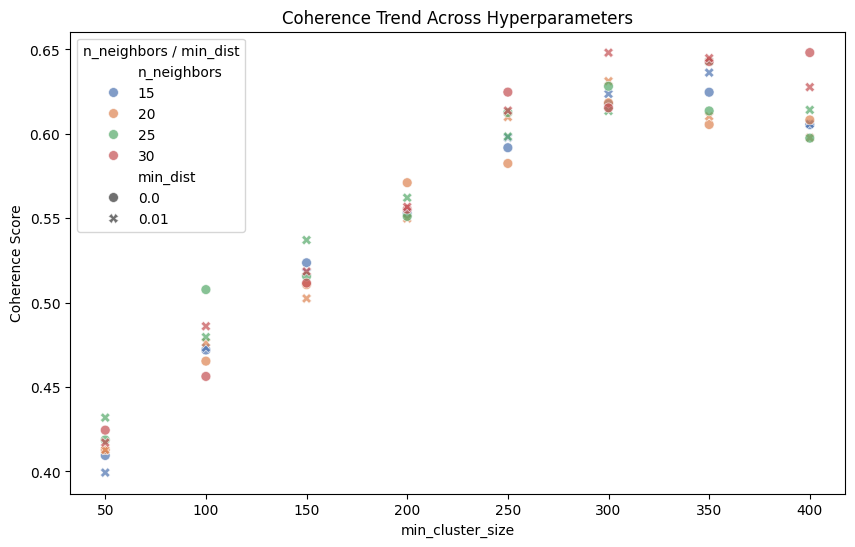

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import pandas as pd

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=hyperparameters,
    x="min_cluster_size",
    y="coherence",
    hue="n_neighbors",      # Different colors for different n_neighbors values
    style="min_dist",       # Different marker styles for different min_dist values
    palette="deep",
    s=50,                   # Marker size
    alpha=0.7
)
plt.title("Coherence Trend Across Hyperparameters")
plt.xlabel("min_cluster_size")
plt.ylabel("Coherence Score")
# Set x-axis tick interval to 50
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(50))

plt.legend(title="n_neighbors / min_dist")
plt.show()

In [20]:
# Show top coherent candidates
coherence_sorted = hyperparameters.sort_values(by="coherence", ascending=False)
coherence_sorted.head(10)

,identifier,n_neighbors,min_dist,min_cluster_size,min_samples,num_topics,coherence,save_path
55,n30_d0.0_cs400,30,0.00,400,200,23,0.648075,Wildfire/model/model_n30_d0.0_cs400
61,n30_d0.01_cs300,30,0.01,300,150,27,0.648029,Wildfire/model/model_n30_d0.01_cs300
62,n30_d0.01_cs350,30,0.01,350,175,27,0.644792,Wildfire/model/model_n30_d0.01_cs350
46,n25_d0.01_cs350,25,0.01,350,175,27,0.642845,Wildfire/model/model_n25_d0.01_cs350
54,n30_d0.0_cs350,30,0.00,350,175,27,0.642772,Wildfire/model/model_n30_d0.0_cs350
14,n15_d0.01_cs350,15,0.01,350,175,27,0.636202,Wildfire/model/model_n15_d0.01_cs350
29,n20_d0.01_cs300,20,0.01,300,150,29,0.631125,Wildfire/model/model_n20_d0.01_cs300
37,n25_d0.0_cs300,25,0.00,300,150,30,0.628131,Wildfire/model/model_n25_d0.0_cs300
63,n30_d0.01_cs400,30,0.01,400,200,27,0.627608,Wildfire/model/model_n30_d0.01_cs400
52,n30_d0.0_cs250,30,0.00,250,125,28,0.624657,Wildfire/model/model_n30_d0.0_cs250
